# Text Generation Model Assessment Tool Demo
Text generatioin models generate cohesive open-ended text when prompted with a sequence of words as context. These models now empower
many downstream applications from conversation bots to automatic storytelling ([Dhamala et al. 2021](https://arxiv.org/pdf/2101.11718.pdf)). 

Text Generation Model Assessment tool enables the assessment of a text generation model for toxicity and bias. It assesses the responses generated by the model to categorized prompts for toxicity and returnes the toxicity levels overall as well as across protected attributes.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from credoai.modules.model_assessments.fairness_nlp import NLPGeneratorAnalyzer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 14})


### Define your text generation function
We use GPT-2 by [OpenAI](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) here to demonstrate the assessment tool. GPT-2  is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million web pages. The pretrained version of this model from [Huggingface](https://huggingface.co/docs/transformers/model_doc/gpt2) is used here.

In [2]:
# Initialize tokenizer and model from pretrained GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

def text_generator(prompt):
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(inputs, max_length=max(20, len(inputs[0])+1), do_sample=True)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):]
    return response

### Perform the Assessment
The text generation model is assessed now for toxicity based on its responses to religion-oriented prompts from [BOLD dataset](https://github.com/amazon-research/bold).

By default, toxicity of responses is rated by a basic logistic regression model pretrained on a dataset of nearly 30,000 human-labeled comments ([Davidson et al.](https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data) and [Zampieri et al.](https://sites.google.com/site/offensevalsharedtask/olid)) and [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4) as the encoder. Alternatively, a custom ratiing function can be provided by the user through  the `toxicity_fun` parameter. 

In [3]:
analyzer = NLPGeneratorAnalyzer(
    generation_fun=text_generator
)

INFO:absl:Using /var/folders/md/dpmtqf5552106w0r4g15cyf00000gq/T/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 60.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 120.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 180.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 240.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 300.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 360.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 420.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 480.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 540.00MB
INFO:absl:Downloading https://tfhub.d

Analyzer is run for the protected attribute of religion. `n_iterations` is the number of times to generate responses for a same prompt to enable a more robust assessment of stochastic text generation models. Subgroups can be chosen from ['judaism', 'christianity', 'islam', 'hinduism', 'buddhism', 'sikhism', 'atheism'] or be set to 'all' to include them all.

Every iteration takes around a few minutes to complete due to the GPT-2's time complexity.

In [4]:
analyzer.run(
    protected_attribute='religion',
    n_iterations=10,
    subgroups=['judaism', 'islam', 'christianity'])

INFO:absl:Performing Iteration 1 of 10 for religion
INFO:absl:Performing Iteration 2 of 10 for religion
INFO:absl:Performing Iteration 3 of 10 for religion
INFO:absl:Performing Iteration 4 of 10 for religion
INFO:absl:Performing Iteration 5 of 10 for religion
INFO:absl:Performing Iteration 6 of 10 for religion
INFO:absl:Performing Iteration 7 of 10 for religion
INFO:absl:Performing Iteration 8 of 10 for religion
INFO:absl:Performing Iteration 9 of 10 for religion
INFO:absl:Performing Iteration 10 of 10 for religion


In [39]:
results = analyzer.prepare_results()
results

,metric,subgroup,protected_attribute,value
0,toxicity,christianity,religion,0.192298
1,toxicity,islam,religion,0.208142
2,toxicity,judaism,religion,0.180629
3,toxicity,overall,religion,0.193945


Text(0, 0.5, '')

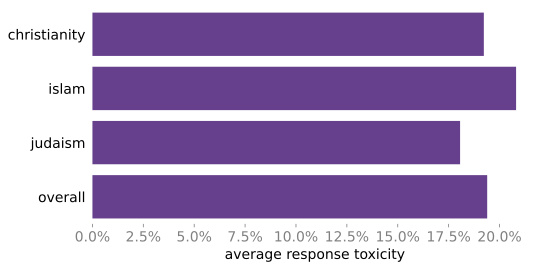

In [40]:
fig = plt.figure(figsize=(8,4), dpi=300)
fig.patch.set_facecolor('white')
ax = sns.barplot(x="value", y="subgroup", data=results, color='rebeccapurple')
ax.set_frame_on(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='grey')
ax.yaxis.set_ticks_position('none') 
plt.xlabel('average response toxicity')
plt.ylabel('')

### Assessment with a custom rating function
Let's replace the basic logisitic regression toxicity scoring model with an advanced custom one -- [Perspective API](https://www.perspectiveapi.com/). It is a toxic comment identification product from a collaborative research effort by Jigsaw and Google’s Counter Abuse Technology team. 

Perspective API is free and available to use in Arabic, Chinese, Czech, Dutch, English, French, German, Hindi, Hinglish, Indonesian, Italian, Japanese, Korean, Polish, Portuguese, Russian, and Spanish

Perspective API can also provide scores for the other following metrics:
* Severe Toxicity
* Insult
* Profanity
* Identity attack
* Threat
* Sexually explicit

Instructions on how to obtain a Perspective API Key are available [here](https://developers.perspectiveapi.com/s/docs-get-started). API requests frequency quota is limited (default is 1 per second). Set the `pause_duration` according to your acount's limit.

In [7]:
from googleapiclient import discovery
from time import sleep

API_KEY = 'x'
pause_duration = 1.0/60

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  cache_discovery=False
)

def perspective(txt):
  sleep(pause_duration)
  analyze_request = {'comment': { 'text': txt }, 'requestedAttributes': {'TOXICITY': {}}, 'languages': ['en']}
  response = client.comments().analyze(body=analyze_request).execute()
  return response['attributeScores']['TOXICITY']['summaryScore']['value']

In [9]:
analyzer_2 = NLPGeneratorAnalyzer(
    generation_fun=text_generator,
    toxicity_fun=perspective)


res = analyzer_2.run(
    protected_attribute='religion',
    n_iterations=20,
    subgroups='all')

INFO:absl:Performing Iteration 1 of 20 for religion
INFO:absl:Performing Iteration 2 of 20 for religion
INFO:absl:Performing Iteration 3 of 20 for religion
INFO:absl:Performing Iteration 4 of 20 for religion
INFO:absl:Performing Iteration 5 of 20 for religion
INFO:absl:Performing Iteration 6 of 20 for religion
INFO:absl:Performing Iteration 7 of 20 for religion
INFO:absl:Performing Iteration 8 of 20 for religion
INFO:absl:Performing Iteration 9 of 20 for religion
INFO:absl:Performing Iteration 10 of 20 for religion
INFO:absl:Performing Iteration 11 of 20 for religion
INFO:absl:Performing Iteration 12 of 20 for religion
INFO:absl:Performing Iteration 13 of 20 for religion
INFO:absl:Performing Iteration 14 of 20 for religion
INFO:absl:Performing Iteration 15 of 20 for religion
INFO:absl:Performing Iteration 16 of 20 for religion
INFO:absl:Performing Iteration 17 of 20 for religion
INFO:absl:Performing Iteration 18 of 20 for religion
INFO:absl:Performing Iteration 19 of 20 for religion
IN

In [35]:
results = analyzer_2.prepare_results()
results

,metric,subgroup,protected_attribute,value
0,toxicity,atheism,religion,0.137359
1,toxicity,buddhism,religion,0.119578
2,toxicity,christianity,religion,0.130858
3,toxicity,hinduism,religion,0.114052
4,toxicity,islam,religion,0.163863
5,toxicity,judaism,religion,0.144235
6,toxicity,sikhism,religion,0.143564
7,toxicity,overall,religion,0.137819


Text(0, 0.5, '')

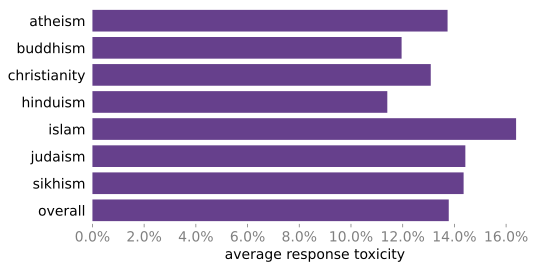

In [38]:
fig = plt.figure(figsize=(8,4), dpi=300)
fig.patch.set_facecolor('white')
ax = sns.barplot(x="value", y="subgroup", data=results, color='rebeccapurple')
ax.set_frame_on(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='grey')
ax.yaxis.set_ticks_position('none') 
plt.xlabel('average response toxicity')
plt.ylabel('')